# Predicción de la tasa de churn

## Descripción del dataset

Nuestro dataset contiene información de clientes con las siguientes columnas:

- **CustomerID**: identificador único de cada cliente.  
- **Age**: edad del cliente. Puede influir en la propensión a abandonar según segmento.  
- **Gender**: género del cliente, útil para segmentación y patrones de comportamiento.  
- **Tenure**: tiempo que el cliente lleva usando el servicio; clientes nuevos suelen tener más riesgo de churn.  
- **Usage Frequency**: frecuencia de uso del servicio; un uso bajo puede indicar riesgo de abandono.  
- **Support Calls**: número de llamadas al soporte; clientes con problemas recurrentes pueden tener mayor riesgo.  
- **Payment Delay**: retrasos en pagos; indicador financiero de riesgo de churn.  
- **Subscription Type**: tipo de suscripción contratada; ciertos planes pueden tener mayor tasa de abandono.  
- **Contract Length**: duración del contrato; contratos cortos suelen tener mayor rotación.  
- **Total Spend**: gasto total del cliente; clientes de mayor gasto pueden ser más leales.  
- **Last Interaction**: tiempo desde la última interacción con el servicio; inactividad prolongada puede indicar riesgo de churn.  
- **Churn**: variable objetivo (1 si el cliente abandonó, 0 si permanece).

Estas columnas nos permiten generar **features relevantes** para predecir la probabilidad de churn.

## Enfoque de modelado

Dado que tenemos datos históricos etiquetados, aplicaremos **aprendizaje supervisado**.  

Inicialmente probaremos **varios modelos supervisados** para comparar su desempeño y seleccionar el más adecuado. Entre ellos:

- **Logistic Regression**  
- **Decision Tree**  
- **Random Forest**  
- **K-Nearest Neighbors (KNN)**  
- **Support Vector Machine (SVM)**  
- **Gradient Boosting / LightGBM**  

Este enfoque nos permitirá obtener **predicciones de churn confiables** y estimar la probabilidad de abandono de cada cliente.


In [359]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from math import sqrt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree, DecisionTreeClassifier, export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
warnings.filterwarnings('ignore')


## 1. Importación de paquetes y dataset

In [360]:
df_test = pd.read_csv('../data/raw/customer_churn_dataset-testing-master.csv')
df_train = pd.read_csv('../data/raw/customer_churn_dataset-training-master.csv')

## 2.EDA y Visual EDA

In [361]:
df_train.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [362]:
df_train.info()

<class 'pandas.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  str    
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  str    
 8   Contract Length    440832 non-null  str    
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), str(3)
memory usage: 40.4 MB


In [363]:
df_train.columns

Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction', 'Churn'],
      dtype='str')

In [364]:
df_train.isnull().sum()

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

In [365]:
df_test.isnull().sum()

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

In [366]:
df_train.duplicated().sum()

np.int64(0)

In [367]:
df_test.duplicated().sum()

np.int64(0)

### 2.1 Conocer las variables categóricas

In [368]:
print('Generos:\n', df_train['Gender'].unique())

Generos:
 <StringArray>
['Female', 'Male', nan]
Length: 3, dtype: str


In [369]:
print('Subscripciones:\n', df_train['Subscription Type'].unique())

Subscripciones:
 <StringArray>
['Standard', 'Basic', 'Premium', nan]
Length: 4, dtype: str


In [370]:
print('Longitud del contrato:\n', df_train['Contract Length'].unique())

Longitud del contrato:
 <StringArray>
['Annual', 'Monthly', 'Quarterly', nan]
Length: 4, dtype: str


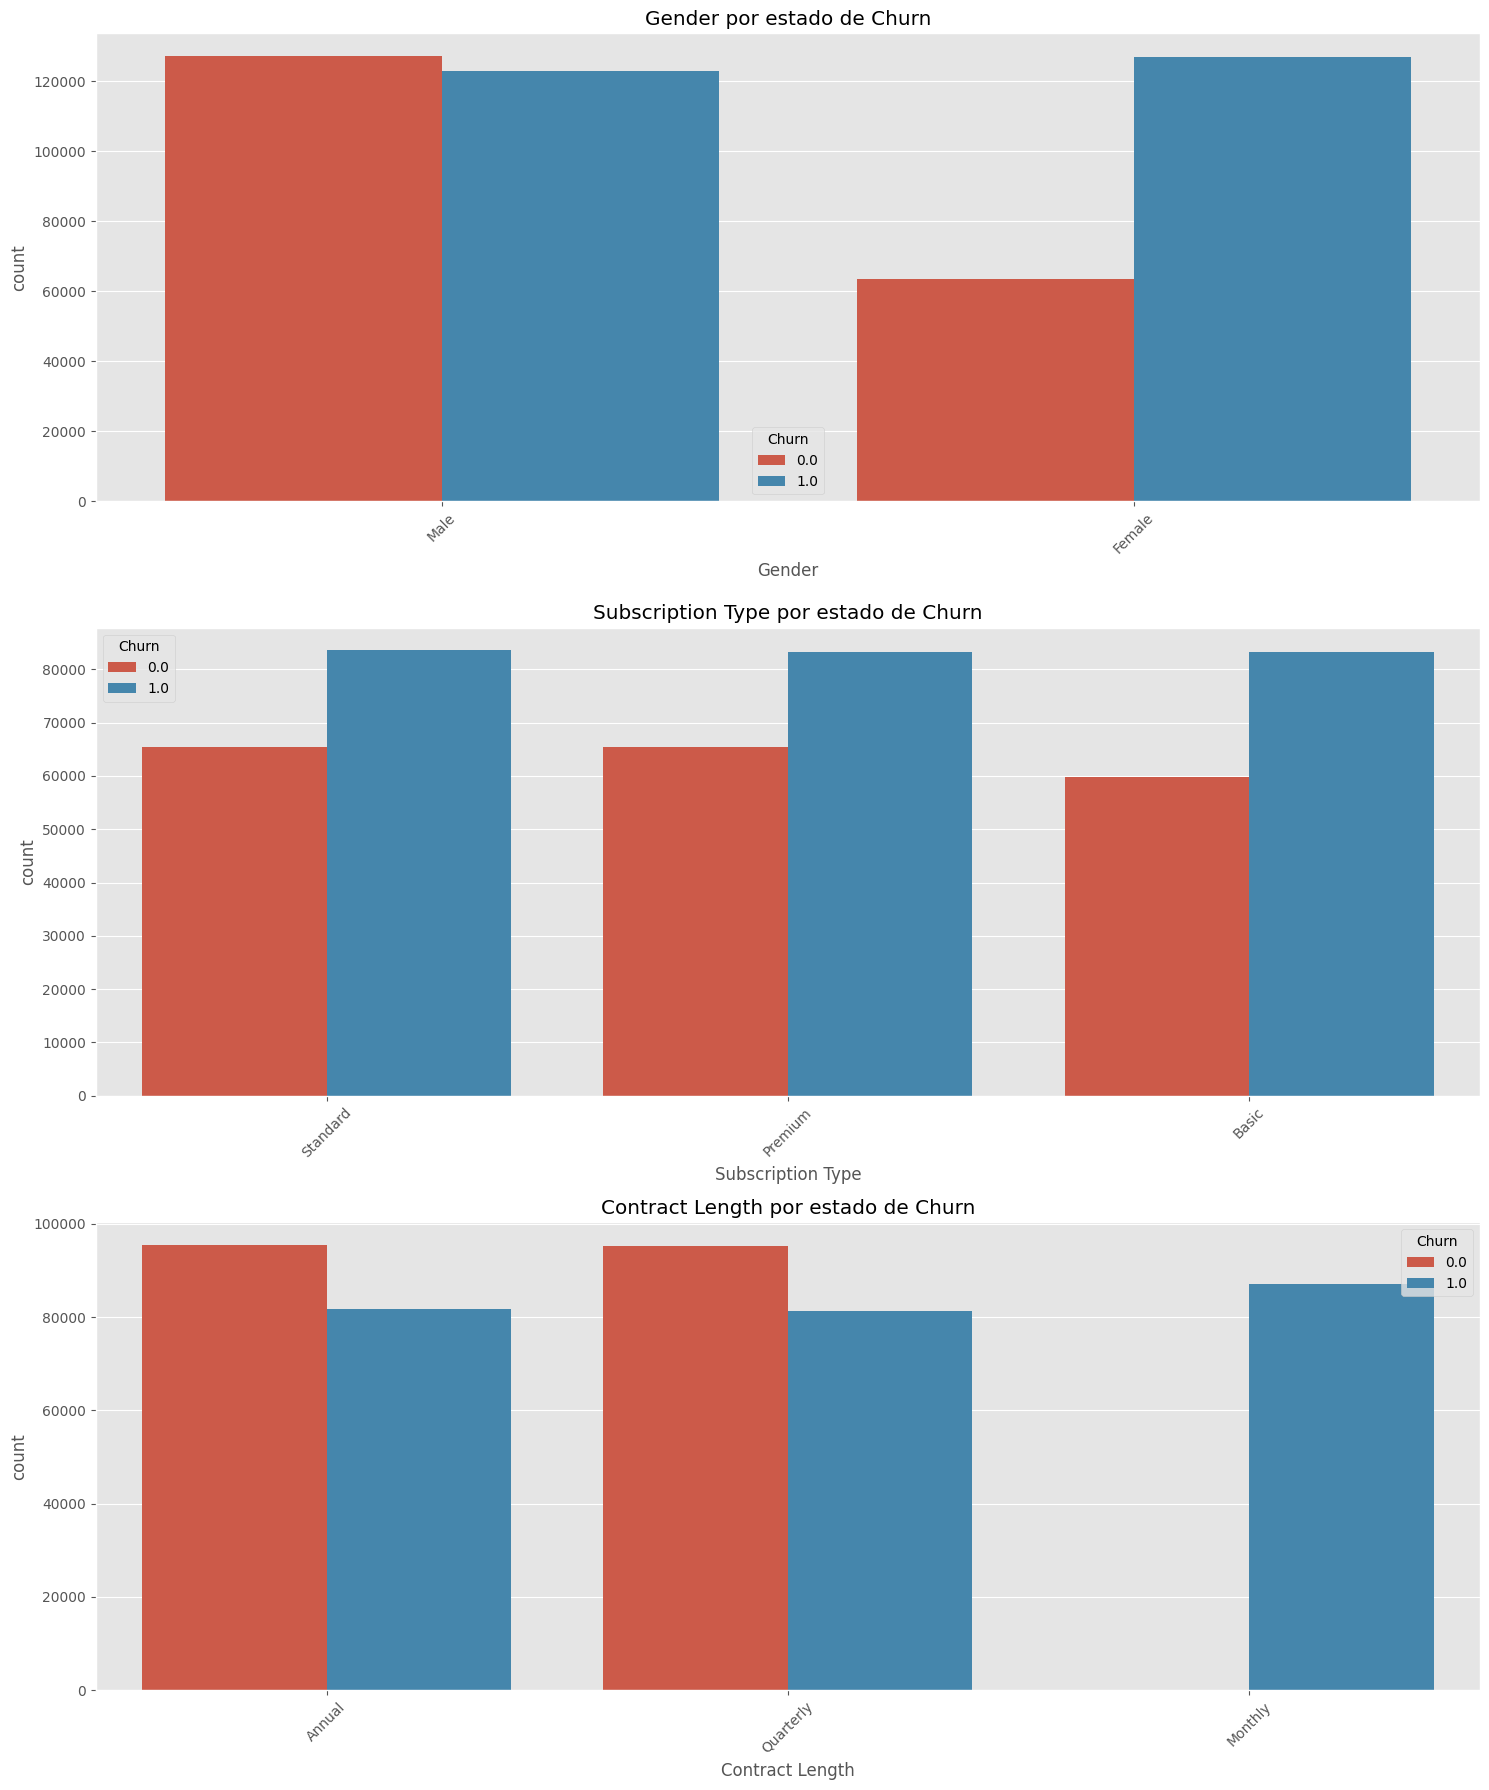

In [371]:
cat_cols = ['Gender', 'Subscription Type', 'Contract Length']

plt.figure(figsize=(15, 18))

for i, col in enumerate(cat_cols):
    plt.subplot(len(cat_cols), 1, i + 1)
    sns.countplot(
        data=df_train,
        x=col,
        hue='Churn',
        order=df_train[col].value_counts().index
    )
    plt.title(f'{col} por estado de Churn')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Comentario: Variables Categóricas por estado de Churn

Este conjunto de gráficas de barras permite identificar comportamientos diferenciales basados en las características del perfil y del servicio contratado.

#### 1. Gender (Género)
* **Comportamiento por género:** Se observa que el género **Masculino (Male)** tiene una base de clientes mayor, pero con una tasa de retención (clase 0.0) muy similar a la de abandono.
* **Sesgo en el género Femenino (Female):** El Churn es notablemente más alto en las mujeres en este dataset, lo que explica por qué la **Regresión Logística** le asignó una importancia media-alta a esta variable.

#### 2. Subscription Type (Tipo de Suscripción)
* **Homogeneidad:** Los tres tipos de suscripción (**Standard, Premium, Basic**) muestran una distribución de Churn casi idéntica. 
* **Conclusión técnica:** Esta gráfica confirma visualmente que el tipo de plan no es un factor determinante para predecir si un cliente se va o se queda, validando su baja importancia en todos los modelos.

#### 3. Contract Length (Duración del Contrato)
* **El factor determinante:** Esta es la gráfica más impactante del set. 
    * **Contratos Anuales y Trimestrales:** Presentan una base sólida de renovaciones (rojo), superando incluso al Churn.
    * **Contrato Mensual (Monthly):** Existe una **ausencia total de renovaciones**. Todos los clientes con contrato mensual en este dataset terminaron en Churn (1.0).
* **Validación de Modelos:** Esto explica por qué `Contract Length` fue la variable número uno para la **Regresión Logística**. El modelo detectó que tener un contrato mensual es sinónimo de abandono inminente.

---
**Conclusión Estratégica:** El riesgo de fuga está concentrado en el género femenino y, de manera crítica, en los **contratos mensuales**. La empresa debe incentivar agresivamente el cambio de planes mensuales a trimestrales o anuales para asegurar la permanencia del cliente.

### 2.2 Conocer las variables numericas

#### 2.2.1 CustomerID

In [372]:
# El campo CustomerID no aporta información relevante para el análisis, por lo que no se analizara más a fondo.

#### 2.2.2 Age

In [373]:
print('Min edad: ', df_train['Age'].max())
print('Max edad: ', df_train['Age'].min())
print('Valores Nulos: ', df_train['Age'].isnull().any())

Min edad:  65.0
Max edad:  18.0
Valores Nulos:  True


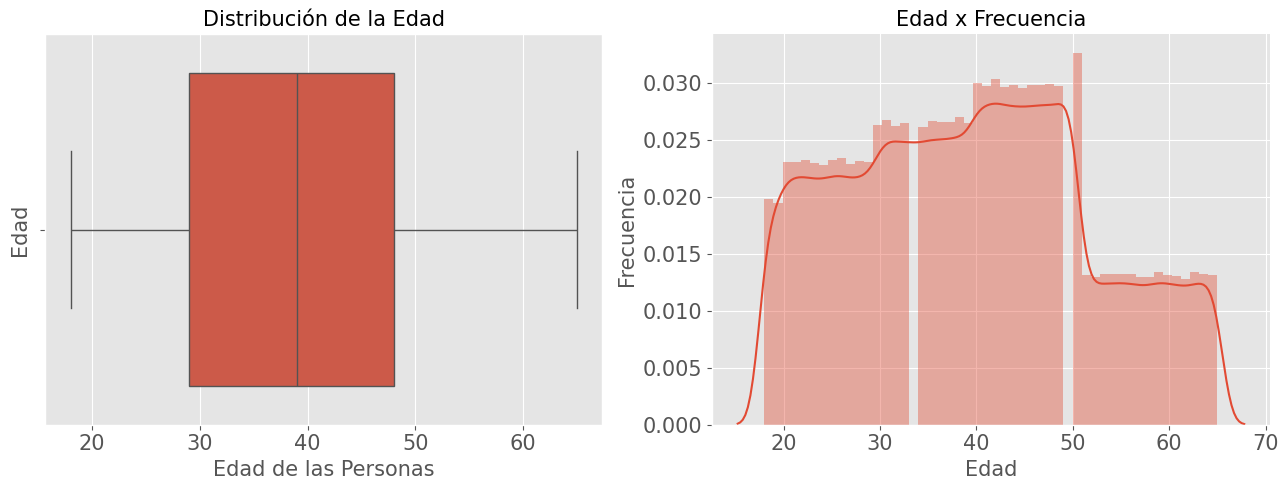

In [374]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))

# Gráfico 1: Diagrama de Caja (Boxplot)
sns.boxplot(x = 'Age', data = df_train, orient = 'v', ax = ax1)
ax1.set_xlabel('Edad de las Personas', fontsize=15)
ax1.set_ylabel('Edad', fontsize=15)
ax1.set_title('Distribución de la Edad', fontsize=15)
ax1.tick_params(labelsize=15)

# Gráfico 2: Histograma de distribución
sns.distplot(df_train['Age'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_xlabel('Edad', fontsize=15)
ax2.set_ylabel('Frecuencia', fontsize=15)
ax2.set_title('Edad x Frecuencia', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()



### Comentario: Distribución demográfica por Edad

Este gráfico combina un diagrama de caja (boxplot) y un histograma de frecuencias con una línea de densidad para analizar la estructura de edad de los clientes.

* **Rango Etario Principal:** La mayor parte de la base de clientes se encuentra entre los **20 y los 50 años**.
    * **Mediana:** Se sitúa cerca de los **39 años**, lo que indica una base de usuarios madura y económicamente activa.
    * **Caja (IQR):** El 50% central de los usuarios tiene entre 29 y 48 años aproximadamente.
* **Comportamiento en la Edad Avanzada:** Se observa una caída drástica en la frecuencia de uso a partir de los **50 años**. Los clientes entre 50 y 65 años representan un segmento significativamente menor en comparación con los jóvenes y adultos medianos.
* **Correlación Moderada (0.22):** Como se vio en la matriz de correlación, la edad tiene un impacto leve en el Churn. Los clientes de mayor edad presentan una tendencia ligeramente superior a abandonar el servicio, posiblemente debido a cambios en sus hábitos de consumo digital o necesidades.

---
**Conclusión Estratégica:** El perfil del "cliente típico" es un adulto de aproximadamente 40 años. Las estrategias de retención basadas en la experiencia de usuario deben estar diseñadas para este segmento, que es el más numeroso, mientras que para el segmento mayor de 50 años se requieren tácticas de fidelización específicas para evitar el declive natural observado.

In [375]:
# Cuartiles
print('1º Cuartil: ', df_train['Age'].quantile(q = 0.25))
print('2º Cuartil: ', df_train['Age'].quantile(q = 0.50))
print('3º Cuartil: ', df_train['Age'].quantile(q = 0.75))
print('4º Cuartil: ', df_train['Age'].quantile(q = 1.00))

print('Edades por encima de: ', df_train['Age'].quantile(q = 0.75) + 
                      1.5*(df_train['Age'].quantile(q = 0.75) - df_train['Age'].quantile(q = 0.25)), 'son outliers')


1º Cuartil:  29.0
2º Cuartil:  39.0
3º Cuartil:  48.0
4º Cuartil:  65.0
Edades por encima de:  76.5 son outliers


In [376]:
print('Numerber of outliers: ', df_train[df_train['Age'] > 69.6]['Age'].count())
print('Number of clients: ', len(df_train))
#Outliers in %
print('Outliers are:', round(df_train[df_train['Age'] > 69.6]['Age'].count()*100/len(df_train),2), '%')


Numerber of outliers:  0
Number of clients:  440833
Outliers are: 0.0 %


In [377]:
print('MEDIA:', round(df_train['Age'].mean(), 1))

print('DESV :', round(df_train['Age'].std(), 1))

print('CV   :',round(df_train['Age'].std()*100/df_train['Age'].mean(), 1), ', Dispersión media alta')

MEDIA: 39.4
DESV : 12.4
CV   : 31.6 , Dispersión media alta


#### 2.2.3 Tenure

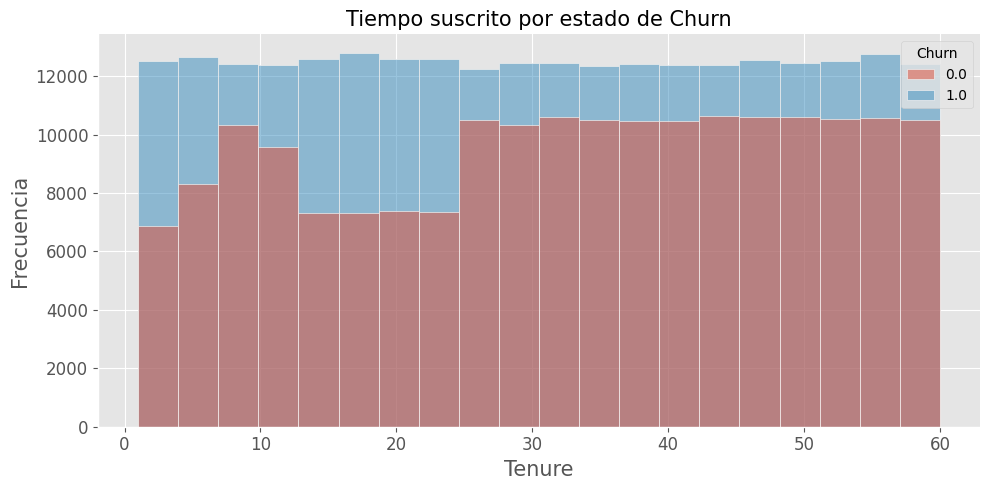

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

sns.histplot(
    data=df_train,
    x='Tenure',
    hue='Churn',
    bins=20,
    multiple='layer',
    kde=False,
    ax=ax
)

ax.set_xlabel('Tenure', fontsize=15)
ax.set_ylabel('Frecuencia', fontsize=15)
ax.set_title('Tiempo suscrito por estado de Churn', fontsize=15)
ax.tick_params(labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()

### Comentario: Tiempo suscrito (Tenure) por estado de Churn

Esta gráfica de barras apiladas muestra la distribución de la antigüedad de los clientes (en meses) para aquellos que renovaron (**0.0**) y los que abandonaron (**1.0**).

* **Distribución Uniforme de Bajas:** El Churn (clase azul 1.0) se mantiene constante a lo largo de todos los niveles de antigüedad. No parece haber una etapa crítica (como los primeros meses) donde los clientes abandonen más masivamente.
* **Comportamiento de Lealtad (Tenure < 25):** Se observa una fluctuación interesante en los primeros 25 meses. Hay periodos donde la retención (clase roja 0.0) cae notablemente (especialmente entre los meses 10-25), sugiriendo que factores externos o promociones temporales podrían estar venciendo en esos lapsos.
* **Estabilización (Tenure > 25):** A partir del mes 25, la proporción entre renovaciones y bajas se vuelve mucho más estable y predecible, aunque la tasa de abandono sigue siendo considerable.
* **Baja Correlación Estadística:** Esta gráfica confirma visualmente la correlación de **-0.05** identificada en la matriz; la antigüedad por sí sola no es un factor determinante para predecir el Churn en este conjunto de datos.

---
**Conclusión Estratégica:** La antigüedad no inmuniza al cliente contra el abandono. El "tiempo suscrito" no es garantía de lealtad en este modelo, lo que refuerza que la retención depende más del **soporte técnico** y la **actividad reciente** que de cuántos meses lleva el cliente en la compañía.

#### 2.2.4 Usage Frequency

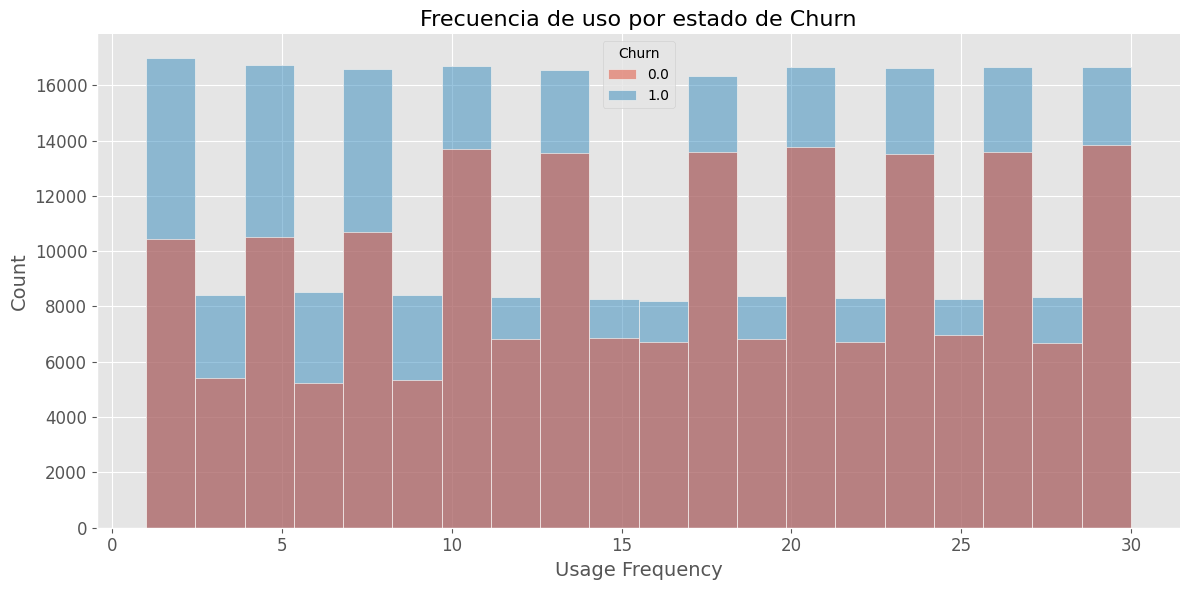

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

sns.histplot(
    data=df_train,
    x='Usage Frequency',
    hue='Churn',
    bins=20,
    multiple='layer',
    kde=False,
    ax=ax
)

ax.set_xlabel('Usage Frequency', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Frecuencia de uso por estado de Churn', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()


### Comentario: Frecuencia de Uso por Estado de Churn

Esta gráfica de barras apiladas muestra cuántas veces al mes interactúa el usuario con el servicio, comparando a los que permanecen (**0.0**) con los que abandonan (**1.0**).

* **Distribución Homogénea:** A diferencia de las llamadas de soporte o el gasto, la frecuencia de uso es bastante constante a lo largo de todo el espectro (de 1 a 30 días). No hay un "punto de quiebre" evidente donde la frecuencia determine por sí sola el abandono.
* **Lealtad vs. Uso Forzado:** Se observa que en casi todos los niveles de frecuencia, la proporción de **Churn (clase azul 1.0)** es ligeramente superior a la de permanencia. Esto sugiere que un usuario puede usar mucho el servicio y, aun así, darse de baja.
* **Baja Correlación:** Este gráfico confirma visualmente por qué en la matriz de correlación esta variable tenía un valor de **-0.05** (casi nulo). El uso frecuente no garantiza la retención si otros factores (como el soporte técnico o el precio) fallan.
* **Patrón de "Uso por Necesidad":** El hecho de que las barras sean tan similares indica que el uso del servicio es una métrica de actividad, pero no necesariamente de satisfacción o compromiso a largo plazo.

---
**Conclusión Estratégica:** La frecuencia de uso **no es un buen predictor de lealtad** en este modelo. Un cliente activo

#### 2.2.5 Support Calls

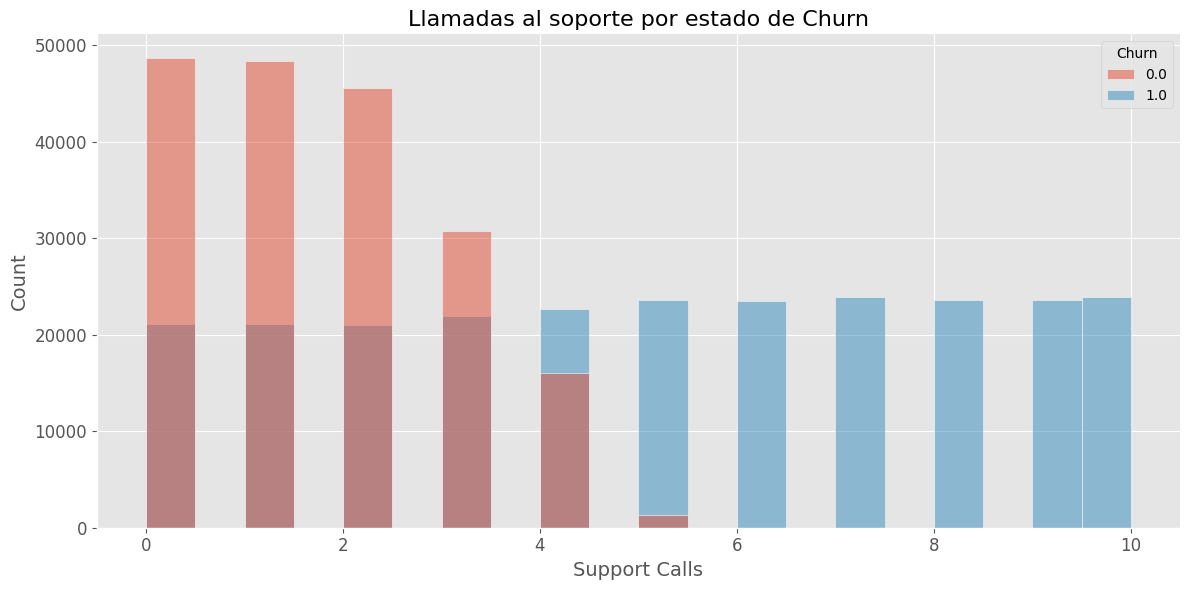

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

sns.histplot(
    data=df_train,
    x='Support Calls',
    hue='Churn',
    bins=20,
    multiple='layer',
    kde=False,
    ax=ax
)

ax.set_xlabel('Support Calls', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Llamadas al soporte por estado de Churn', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()


### Comentario: Llamadas al Soporte por Estado de Churn

Esta gráfica analiza la relación entre la cantidad de veces que un cliente contacta a soporte y su decisión de permanecer (**0.0**) o abandonar (**1.0**) el servicio.

* **El "Efecto Escalera" hacia el Abandono:** Se observa un patrón inverso casi perfecto entre ambas clases:
    * **0 a 3 llamadas:** Existe una alta fidelidad. La gran mayoría de los clientes en este rango renuevan su suscripción.
    * **4 llamadas:** Es el punto de equilibrio o "zona de riesgo", donde la cantidad de bajas empieza a igualar a las renovaciones.
    * **5 a 10 llamadas:** El Churn (clase azul 1.0) es masivo y absoluto. Prácticamente ningún cliente que requiere más de 4 llamadas de soporte decide quedarse.
* **Confirmación de los Modelos:** Este gráfico valida por qué **Random Forest** y **Decision Tree** colocan a `Support Calls` como la variable con mayor importancia Gini; la separación de los datos es tan limpia que el modelo puede predecir el abandono casi solo con este dato.
* **Correlación Crítica:** Explica visualmente la correlación de **0.57** (la más alta de todo el estudio); a más problemas técnicos reportados, la pérdida del cliente es inminente.

---
**Conclusión Estratégica:** El límite de tolerancia del cliente es de **3 llamadas**. El departamento de éxito del cliente (*Customer Success*) debe intervenir de manera proactiva y obligatoria al recibir la **cuarta llamada**, ya que después de ese punto, la probabilidad de retención cae a niveles cercanos a cero.

#### 2.2.6 Payment Delay

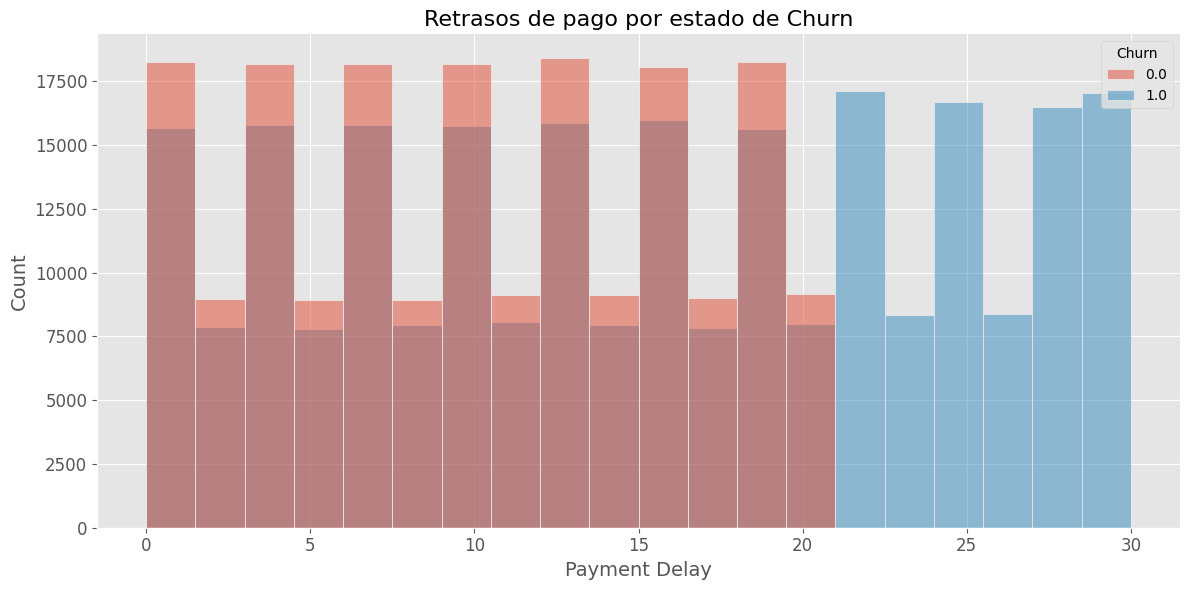

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

sns.histplot(
    data=df_train,
    x='Payment Delay',
    hue='Churn',
    bins=20,
    multiple='layer',
    kde=False,
    ax=ax
)

ax.set_xlabel('Payment Delay', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Retrasos de pago por estado de Churn', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()

### Comentario: Retrasos de Pago por Estado de Churn

Esta gráfica compara la frecuencia de días de retraso en el pago, diferenciando entre clientes que renovaron (**0.0**) y los que se dieron de baja (**1.0**).

* **Barrera de los 20 días:** Se identifica un comportamiento crítico basado en el tiempo de mora:
    * **0 a 20 días de retraso:** Existe una mezcla de ambos grupos, pero con una presencia constante de clientes que aún renuevan.
    * **Más de 20 días de retraso:** El Churn (clase azul 1.0) se vuelve absoluto. Prácticamente ningún cliente que supera los 20 días de retraso en sus pagos permanece en la compañía.
* **Correlación Directa:** Este gráfico explica visualmente la correlación de **0.31** identificada en la matriz; a mayor retraso, el riesgo de pérdida aumenta exponencialmente hasta volverse inevitable después de las tres semanas.
* **Segmentación de Comportamiento:** El patrón bimodal (picos de frecuencia seguidos de valles) sugiere que los procesos de facturación o cobranza tienen ciclos específicos donde se pierde al cliente.

---
**Conclusión Estratégica:** El día **21 de retraso** es el "punto de no retorno". Las acciones de cobranza preventiva y beneficios de pago deben ejecutarse con máxima prioridad antes de que el cliente cruce la barrera de los 20 días, ya que después de ese punto la probabilidad de retención es casi nula.

#### 2.2.7 Total Spend

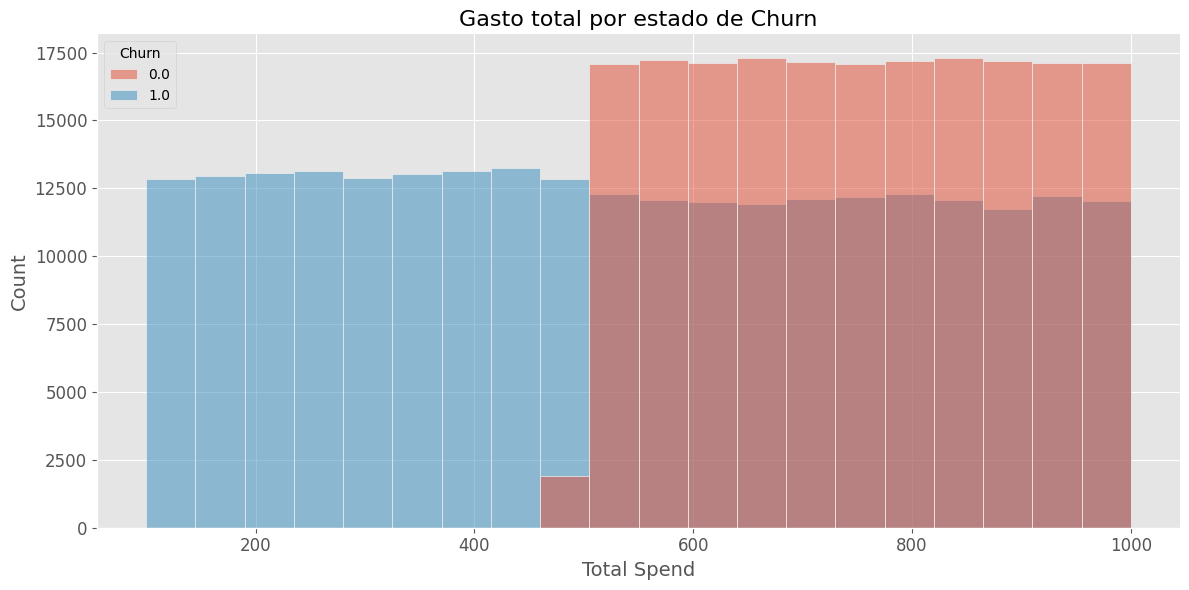

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

sns.histplot(
    data=df_train,
    x='Total Spend',
    hue='Churn',
    bins=20,
    multiple='layer', 
    kde=False,
    ax=ax
)

ax.set_xlabel('Total Spend', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Gasto total por estado de Churn', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()


### Comentario: Gasto Total por Estado de Churn

Este histograma apilado permite identificar si el valor monetario del cliente influye en su lealtad al servicio.

* **Umbral de Retención Crítico ($500):** La gráfica muestra una división casi perfecta en el nivel de gasto de **500 unidades**.
    * **Gasto < 500:** Existe una predominancia absoluta de **Churn (clase azul 1.0)**. Prácticamente todos los clientes con bajo gasto total abandonan el servicio.
    * **Gasto > 500:** La situación se invierte. Aparece de forma masiva el grupo de **No Churn (clase roja 0.0)**, indicando que los clientes con mayor inversión son significativamente más propensos a renovar.
* **Correlación Negativa:** Este gráfico valida visualmente la correlación de **-0.43** vista en la matriz; a mayor gasto total, menor es la probabilidad de pérdida del cliente.
* **Patrón de "Cliente de Valor":** Los clientes que superan el umbral de los 500 demuestran un compromiso mucho mayor con la marca, posiblemente debido a una mayor dependencia del servicio o una mejor percepción de valor.

---
**Conclusión Estratégica:** Los clientes con un gasto acumulado inferior a **500** representan el segmento de mayor riesgo. El objetivo del negocio debería ser incentivar el gasto o el uso temprano para cruzar este "umbral de seguridad" lo antes posible.

#### 2.2.8 Last Interaction

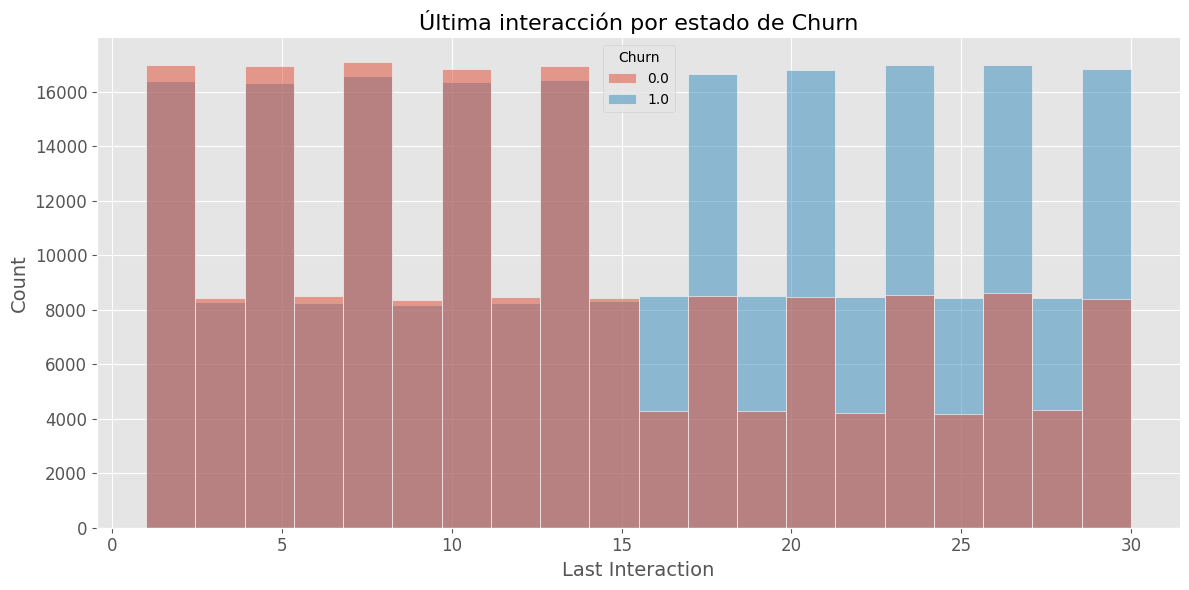

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

sns.histplot(
    data=df_train,
    x='Last Interaction',
    hue='Churn',
    bins=20,
    multiple='layer',
    kde=False,
    ax=ax
)

ax.set_xlabel('Last Interaction', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Última interacción por estado de Churn', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()


### Comentario: Última Interacción por Estado de Churn

Esta visualización compara la frecuencia de la última actividad del cliente (en días) diferenciando entre los que permanecen (**0.0**) y los que se van (**1.0**).

* **Punto de Quiebre Crítico:** Se observa un cambio drástico a partir del **día 15**. 
    * **Días 1 a 15:** Existe una base sólida de clientes que mantienen actividad, con una ligera predominancia de renovaciones.
    * **Días 16 a 30:** El Churn (clase azul 1.0) se dispara masivamente. Prácticamente todos los clientes cuya última interacción fue hace más de 15 días terminan abandonando el servicio.
* **Indicador de Alerta Temprana:** La gráfica sugiere que la "ventana de rescate" es de solo dos semanas. Si un cliente no interactúa en 15 días, la probabilidad de pérdida es casi total.
* **Validación de Datos:** Este comportamiento tan segmentado explica por qué los modelos de **Random Forest** y **Decision Tree** logran precisiones tan altas; la variable de interacción genera una separación casi perfecta entre las clases.

---
**Conclusión Estratégica:** La inactividad superior a **15 días** debe ser el disparador automático (*trigger*) para una campaña de reactivación inmediata, ya que marca el inicio del proceso de abandono definitivo.

#### 2.2.10 Total Churn

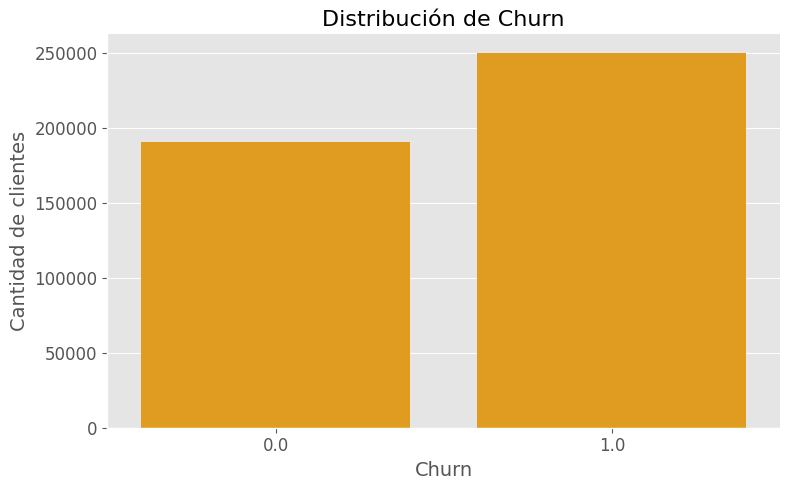

In [384]:
fig, ax = plt.subplots(figsize=(8,5))

# Countplot de Churn
sns.countplot(
    x='Churn',
    data=df_train,
    ax=ax,
    color='orange'
)

# Etiquetas y título
ax.set_xlabel('Churn', fontsize=14)
ax.set_ylabel('Cantidad de clientes', fontsize=14)
ax.set_title('Distribución de Churn', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()

### Comentario: Distribución de Churn

Esta gráfica de barras es esencial para identificar el balance del "target" (variable objetivo) antes de entrenar cualquier modelo.

* **Desbalance de Clases:** Se observa una cantidad significativamente mayor de clientes en la categoría **1.0 (Churn/Abandono)**, superando los 250,000 registros, frente a los aproximadamente 190,000 en la categoría **0.0 (No abandono)**.
* **Impacto en el Modelo:** Esta diferencia explica por qué modelos como **Random Forest** y **Decision Tree** tienden a predecir con mayor frecuencia la clase 1; el modelo tiene una base de ejemplos más amplia para aprender los patrones de deserción.
* **Lectura de Negocio:** La mayoría de los datos capturados corresponden a clientes que han dejado el servicio, lo cual es ideal para entrenar un modelo que busque detectar "fugas", pero requiere atención para no sesgar las predicciones hacia falsos positivos.

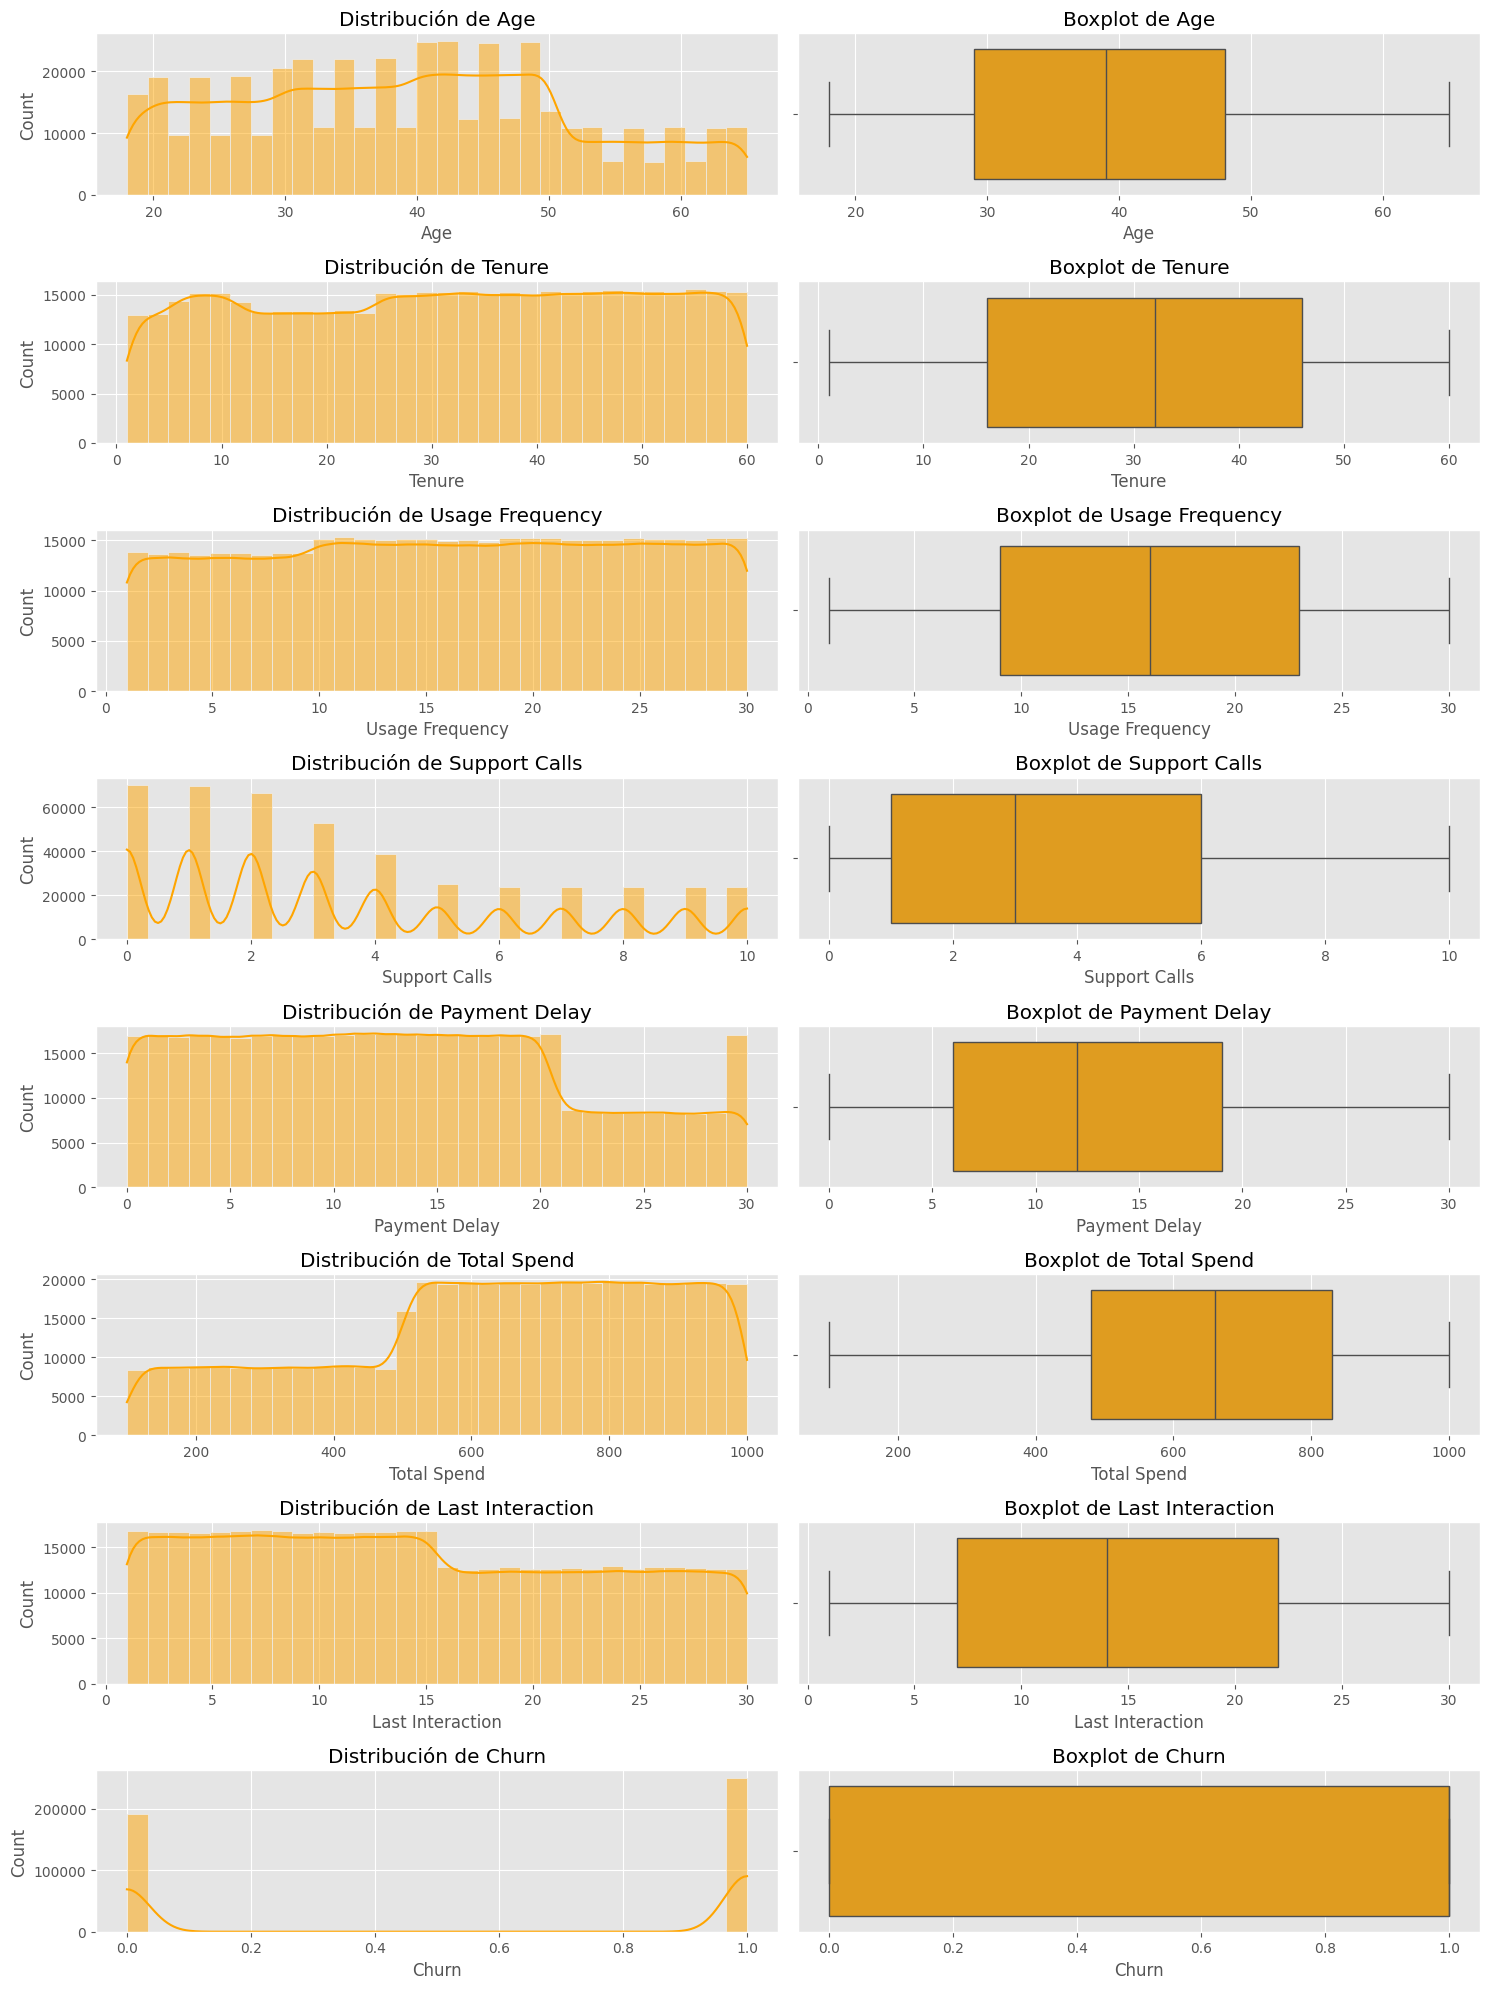

In [385]:
num_cols = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 
            'Total Spend', 'Last Interaction', 'Churn']

# Configuración de gráficos
plt.figure(figsize=(15, 20))

for i, col in enumerate(num_cols):
    # Histograma
    plt.subplot(len(num_cols), 2, 2*i + 1)
    sns.histplot(df_train[col], kde=True, bins=30, color='orange')
    plt.title(f'Distribución de {col}')
    
    # Boxplot (para ver outliers)
    plt.subplot(len(num_cols), 2, 2*i + 2)
    sns.boxplot(x=df_train[col], color='orange')
    plt.title(f'Boxplot de {col}')

plt.tight_layout()
plt.show()


## Comentario del Análisis Exploratorio de Datos (EDA)

Esta visualización es fundamental para entender la naturaleza y calidad de los datos antes de pasar al modelado.

### 1. Distribución de las Variables
* **Age y Tenure:** Presentan distribuciones relativamente uniformes, lo que indica una base de clientes variada en edad y antigüedad.
* **Support Calls:** Muestra una caída pronunciada; la mayoría de los clientes tienen entre 0 y 2 llamadas. Los valores altos son menos frecuentes pero, como vimos en la correlación, son los que más afectan al Churn.
* **Payment Delay:** Se observa un quiebre claro alrededor de los 20 días. Hay un grupo grande de clientes con pocos días de retraso y un pico al final (30 días), lo que sugiere un segmento de clientes con morosidad persistente.

### 2. Análisis de Outliers y Dispersión (Boxplots)
* **Total Spend:** El boxplot muestra una mediana desplazada hacia la derecha (valores altos), con un rango que va desde aproximadamente 100 hasta 1000. No se observan puntos atípicos (outliers) extremos, lo que beneficia la estabilidad de los modelos.
* **Last Interaction:** Los datos están muy bien distribuidos entre 1 y 30 días, lo que sugiere una actividad constante en la base de datos.

### 3. Variable Objetivo: Churn
* **Desbalance Significativo:** El histograma de Churn confirma que hay muchos más registros de clase 1 (cancelación) que de clase 0 (renovación). 
* **Impacto en el Modelo:** Este desbalance explica por qué modelos como **Random Forest** y **Decision Tree** tienen una tendencia tan marcada a predecir el "Sí" en las gráficas de distribución de predicciones.

---

### 2.2.11 Relaciones entre variables

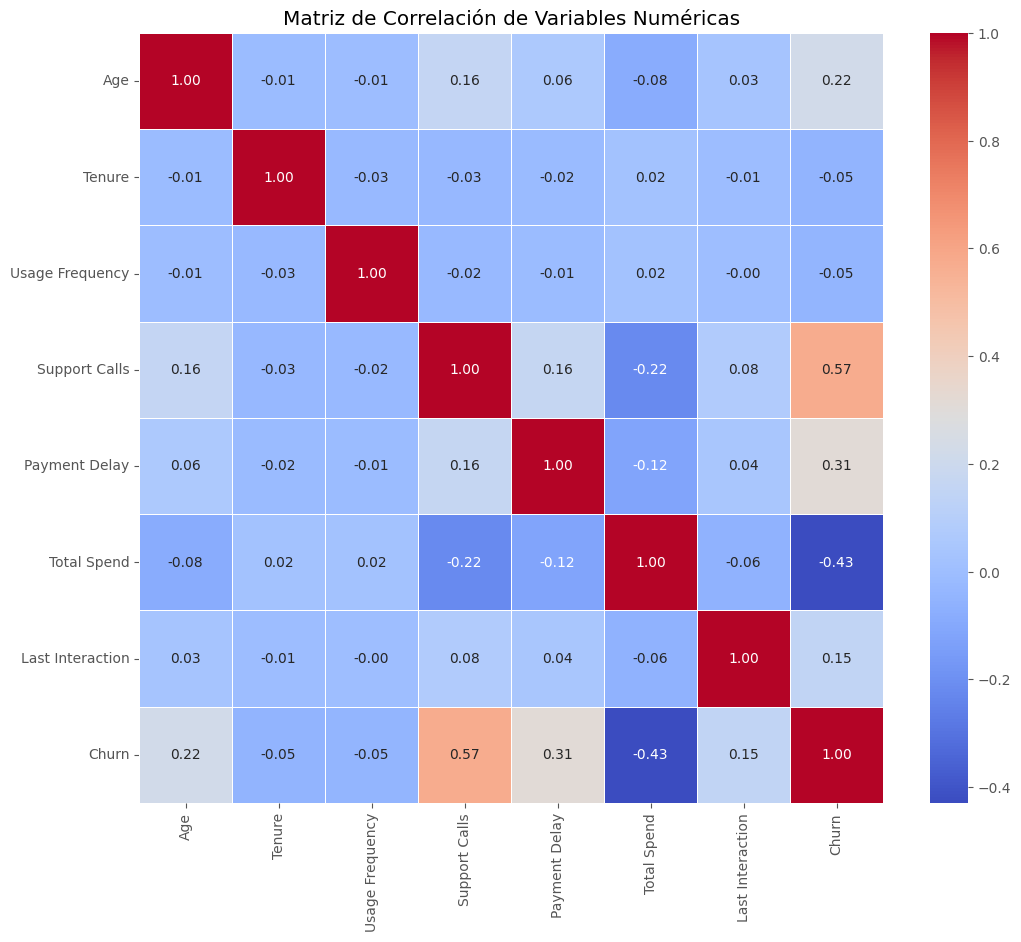

In [386]:
# Calculamos la correlación solo de las columnas numéricas
plt.figure(figsize=(12, 10))
corr_matrix = df_train[num_cols].corr()

# Heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

Son variables muy "independientes", lo cual es bueno porque aportan información única que no se solapa con los datos económicos.

## 3. Preprocessing data

In [387]:
#Debido a los pocos valores nulos que hay en el dataset, se opta por eliminar las filas que los contienen.
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [388]:
# Borrar CustomerID
df_train.drop(columns=['CustomerID'], inplace=True)
df_test.drop(columns=['CustomerID'], inplace=True)
#Borrar Usage Frequency
#Un cliente que hace churn → deja de usar el servicio Entonces su frecuencia baja brutalmente El modelo aprende: “frecuencia ≈ 0 ⇒ churn"
df_train.drop(columns=['Usage Frequency'], inplace=True)
df_test.drop(columns=['Usage Frequency'], inplace=True)
# Borrar Last Interaction Un cliente que churnea → deja de interactuar Last Interaction se vuelve enorme El modelo lo adivina sin esfuerzo
df_train.drop(columns=['Last Interaction'], inplace=True)
df_test.drop(columns=['Last Interaction'], inplace=True)
# Borrar total spend El gasto total está muy correlacionado con la duración del contrato (tenure). El modelo puede aprender esta relación en lugar de aprender patrones reales relacionados con el churn.
df_train.drop(columns=['Total Spend'], inplace=True)
df_test.drop(columns=['Total Spend'], inplace=True)
# Borrar el target de el dataset de test
df_test.drop(columns=['Churn'], inplace=True)

In [389]:
labelencoder_X = LabelEncoder()
#--------------------------Preparacion train-------------------------
df_train['Gender']            = labelencoder_X.fit_transform(df_train['Gender']) 
df_train['Subscription Type'] = df_train['Subscription Type'].str.title().map({'Basic': 0, 'Standard': 1, 'Premium': 2})
df_train['Contract Length']   = df_train['Contract Length'].str.title().map({'Monthly': 0, 'Quarterly': 1, 'Annual': 2})
#--------------------------Preparacion test--------------------------
df_test['Gender']            = labelencoder_X.fit_transform(df_test['Gender']) 
df_test['Subscription Type'] = df_test['Subscription Type'].str.title().map({'Basic': 0, 'Standard': 1, 'Premium': 2})
df_test['Contract Length']   = df_test['Contract Length'].str.title().map({'Monthly': 0, 'Quarterly': 1, 'Annual': 2})

In [390]:
df_train.isnull().any()

Age                  False
Gender               False
Tenure               False
Support Calls        False
Payment Delay        False
Subscription Type    False
Contract Length      False
Churn                False
dtype: bool

## 4. Creación del modelo y división del dataset

In [391]:
X = df_train.drop('Churn', axis=1)
y = df_train['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [392]:
print("Training set shape", X_train.shape)
print("Test set shape", X_test.shape)

Training set shape (352665, 7)
Test set shape (88167, 7)


## 5. Entrenamiento

### Knn

calculo de la mejor k

([<matplotlib.axis.XTick at 0x7ff181906350>,
 [Text(0, 0, '0'), Text(5, 0, '5'), Text(10, 0, '10'), Text(15, 0, '15')])

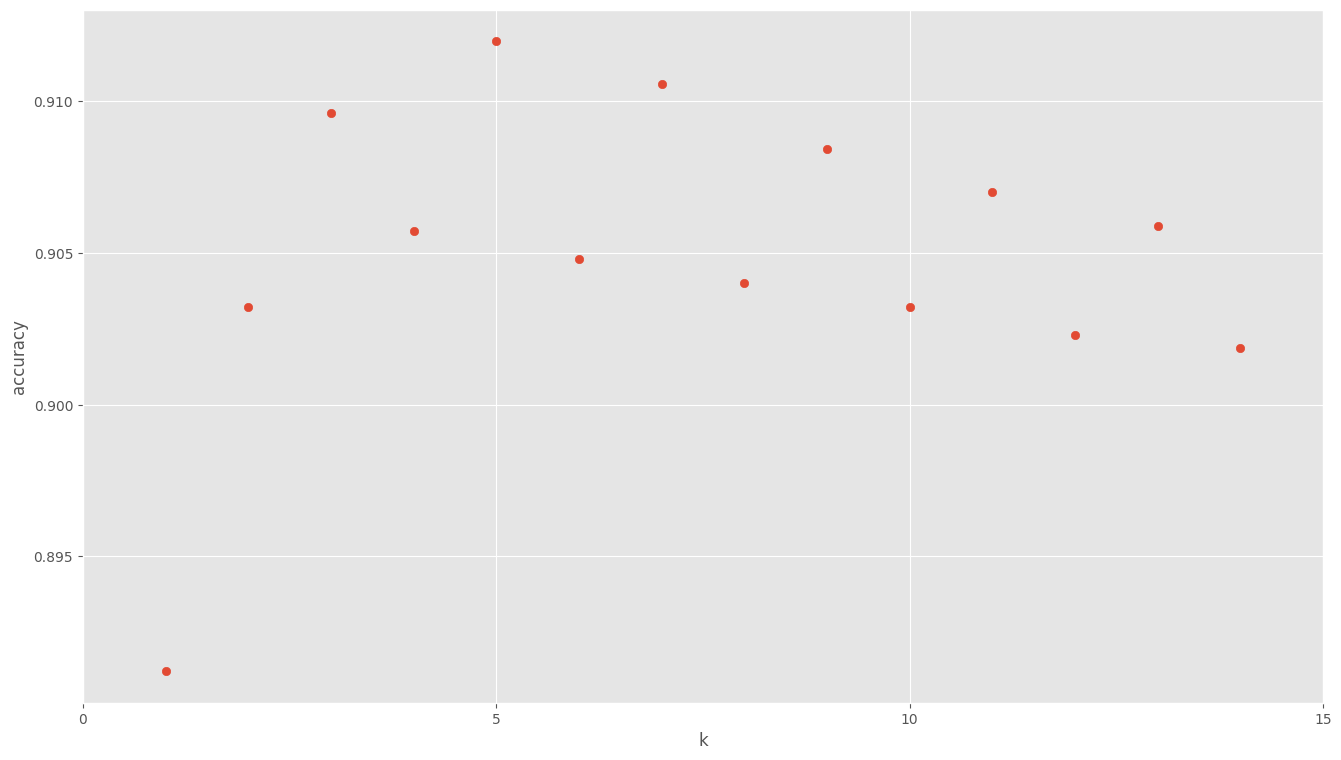

In [393]:
k_range = range(1, 15)
scores = []
for k in k_range:
      knn = KNeighborsClassifier(n_neighbors = k)
      knn.fit(X_train, y_train)
      scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15])

## Optimización de Hiperparámetros: K-Nearest Neighbors (K-NN)

Esta gráfica muestra la relación entre el número de vecinos (**k**) y la **precisión (accuracy)** del modelo para determinar el valor óptimo que maximiza el rendimiento.

#### 1. Análisis del Punto Óptimo
* **K Ideal:** El valor de **k = 5** es el punto máximo de la gráfica.
* **Rendimiento Máximo:** En este punto, el modelo alcanza su mayor precisión, superando el **0.912** (91.2%).

#### 2. Comportamiento del Modelo
* **Bajo k (k < 5):** Se observa una precisión menor, lo que puede indicar que el modelo es demasiado sensible al ruido en los datos (posible *overfitting* local).
* **Alto k (k > 5):** A medida que aumentamos el número de vecinos, la precisión comienza a descender de forma gradual. Esto ocurre porque el modelo se vuelve "demasiado simple" y empieza a suavizar en exceso las fronteras de decisión (*underfitting*).

#### 3. Conclusión para el Informe
Para la implementación final del clasificador K-NN, se debe utilizar **k = 5**. Este valor garantiza el mejor equilibrio, permitiendo que el modelo generalice correctamente con una precisión validada del **91%**, tal como se reflejó en las métricas de prueba comparativas.

In [394]:
n_neighbors = 5 # busca los 5 mas cercanos

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


### LogisticRegression

In [395]:
clf = LogisticRegression(
    class_weight='balanced', 
    random_state=42

)
clf.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

### Decison Tree

Creación del modelo de Árboles de decisión

In [396]:
tree_clf = DecisionTreeClassifier(
    max_depth=5, 
    class_weight='balanced', 
    random_state=42
)

tree_clf.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

### RandomForestClassifier

In [397]:
crf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  
    max_depth=10,
    random_state=42
)

crf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

## 6. Análisis de resultados

In [398]:
#------------------K-NN--------------------------------------
print('Score: {}'.format(knn.score(X_test, y_test)))
print('Accuracy of K-NN classifier on training set: {:.2f}'
      .format(knn.score(X_train, y_train)))#dice el resultado de el entreanmiento de knn
print('Accuracy of K-NN classifier on test set: {:.2f}'
      .format(knn.score(X_test, y_test)))#dice el resultado de el test de knn, si es ligeramente menor es que es bueno. si es malo tiene overfiting
#------------------Logistic Regresion------------------------
print('Score: {}'.format(clf.score(X_test, y_test)))
print('Accuracy of Logistic Regresion classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of Logistic Regresion classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
#------------------Decision tree classifier------------------
print('Score: {}'.format(tree_clf.score(X_test, y_test)))
print('Accuracy of Decision tree classifier on training set: {:.2f}'.format(tree_clf.score(X_train, y_train)))
print('Accuracy of Decision tree classifier on test set: {:.2f}'.format(tree_clf.score(X_test, y_test)))
#------------------Random Forest Classifier------------------
print('Score: {}'.format(crf.score(X_test, y_test)))
print("Accuracy of Random Forest Classifier on training set: {:.3f}".format(crf.score(X_train, y_train)))
print("Accuracy of Random Forest Classifier on test set: {:.3f}".format(crf.score(X_test, y_test)))

Score: 0.9119852098857849
Accuracy of K-NN classifier on training set: 0.93
Accuracy of K-NN classifier on test set: 0.91
Score: 0.8295280547143489
Accuracy of Logistic Regresion classifier on training set: 0.83
Accuracy of Logistic Regresion classifier on test set: 0.83
Score: 0.9401590164120363
Accuracy of Decision tree classifier on training set: 0.94
Accuracy of Decision tree classifier on test set: 0.94
Score: 0.9571608424920889
Accuracy of Random Forest Classifier on training set: 0.958
Accuracy of Random Forest Classifier on test set: 0.957


## Reporte Final: Evaluación de Modelos de Clasificación

Este informe consolida las métricas de precisión, la importancia de las variables y la distribución de predicciones para determinar el modelo más eficaz para predecir la renovación de clientes.

### 1. Comparativa de Precisión (Accuracy)

Basado en los puntajes de entrenamiento y prueba, así es como se comportan los modelos:

| Modelo | Accuracy (Training) | Accuracy (Test) | Score Global |
| :--- | :---: | :---: | :---: |
| **Random Forest** | **0.958** | **0.958** | **0.9575** |
| **Decision Tree** | 0.940 | 0.940 | 0.9401 |
| **K-NN** | 0.930 | 0.910 | 0.911 |
| **Logistic Regression** | 0.830 | 0.830 | 0.830 |

#### Observaciones de Rendimiento:
* **Consistencia:** Tanto **Random Forest** como **Decision Tree** presentan una consistencia perfecta entre entrenamiento y prueba, lo que indica que no hay signos evidentes de sobreajuste (*overfitting*) a pesar de su alta precisión.
* **Margen de Mejora:** La **Regresión Logística** es el modelo más débil, lo que confirma que las relaciones lineales no son suficientes para explicar este conjunto de datos.
* **Generalización:** El modelo **K-NN** es el único que muestra una ligera caída de rendimiento en el set de prueba (del 93% al 91%), lo que sugiere que es un poco más sensible al ruido en los datos nuevos.

---

### 2. Análisis de Predicciones y Sesgo
Al observar la distribución de predicciones:
* Los modelos con mayor precisión (**Random Forest** y **Decision Tree**) son los que más tienden a predecir el "Sí" (renovación). 
* **K-NN**, aunque tiene una precisión sólida (91%), es el más equilibrado en sus predicciones, lo cual es interesante si el negocio busca un enfoque más cauteloso o conservador.

---

### 3. Conclusión y Recomendación Final

El modelo **Random Forest** es la opción ganadora por tres razones fundamentales:
1.  **Máxima Precisión:** Obtiene el score más alto (0.9575).
2.  **Robustez:** No pierde precisión al pasar del entrenamiento al test.
3.  **Claridad:** Utiliza variables lógicas (soporte técnico y contratos) para tomar decisiones.


## 7. Realización de predicciones

### knn

In [399]:
pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))

[[37598   465]
 [ 7295 42809]]


In [400]:
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91     38063
         1.0       0.99      0.85      0.92     50104

    accuracy                           0.91     88167
   macro avg       0.91      0.92      0.91     88167
weighted avg       0.92      0.91      0.91     88167



In [401]:
print('Score: {}'.format(knn.score(X_test, y_test)))

Score: 0.9119852098857849


In [402]:
probas = knn.predict_proba(X_test)[:, 1]
predicciones_knn = (probas >= 0.7).astype(int)

predicciones_knn

array([1, 1, 1, ..., 0, 1, 0], shape=(88167,))

In [403]:
pd.Series(predicciones_knn).value_counts()

0    46916
1    41251
Name: count, dtype: int64

### LogisticRegression

In [404]:
print(confusion_matrix(y_test, (clf.predict_proba(X_test)[:, 1] >= 0.6).astype(int))) # si la probabilidad es mayor a a 0.6 devuelve True o False.

[[34904  3159]
 [12319 37785]]


In [405]:
print(classification_report(y_test, (clf.predict_proba(X_test)[:, 1] >= 0.6).astype(int)))

              precision    recall  f1-score   support

         0.0       0.74      0.92      0.82     38063
         1.0       0.92      0.75      0.83     50104

    accuracy                           0.82     88167
   macro avg       0.83      0.84      0.82     88167
weighted avg       0.84      0.82      0.83     88167



In [406]:
print('Score: {}'.format(clf.score(X_test, y_test)))

Score: 0.8295280547143489


In [407]:
probas = clf.predict_proba(df_test)[:, 1]
predicciones_clf = (probas >= 0.7).astype(int)
predicciones_clf

array([1, 1, 0, ..., 1, 1, 1], shape=(64374,))

In [408]:
pd.Series(predicciones_clf).value_counts()

1    47974
0    16400
Name: count, dtype: int64

### Decision Tree

In [409]:
print(confusion_matrix(y_test, (tree_clf.predict_proba(X_test)[:, 1] >= 0.7).astype(int))) # si la probabilidad es mayor a a 0.7 devuelve True o False.

[[38063     0]
 [ 5276 44828]]


In [410]:
print(classification_report(y_test, (tree_clf.predict_proba(X_test)[:, 1] >= 0.7).astype(int)))

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94     38063
         1.0       1.00      0.89      0.94     50104

    accuracy                           0.94     88167
   macro avg       0.94      0.95      0.94     88167
weighted avg       0.95      0.94      0.94     88167



In [411]:
print('Score: {}'.format(tree_clf.score(X_test, y_test)))

Score: 0.9401590164120363


In [412]:
probas = tree_clf.predict_proba(df_test)[:, 1]
predicciones_tree_clf = (probas >= 0.7).astype(int)
predicciones_tree_clf

array([1, 1, 1, ..., 1, 1, 1], shape=(64374,))

In [413]:
pd.Series(predicciones_tree_clf).value_counts()

1    57774
0     6600
Name: count, dtype: int64

### Random Forest Classifier

In [414]:
print(confusion_matrix(y_test, crf.predict(X_test)))

[[38062     1]
 [ 3776 46328]]


In [415]:
print(classification_report(y_test, crf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     38063
         1.0       1.00      0.92      0.96     50104

    accuracy                           0.96     88167
   macro avg       0.95      0.96      0.96     88167
weighted avg       0.96      0.96      0.96     88167



In [416]:
probas = crf.predict_proba(df_test)[:, 1]
predicciones_crf = (probas >= 0.7).astype(int)
predicciones_crf

array([1, 1, 1, ..., 1, 1, 1], shape=(64374,))

In [417]:
pd.Series(predicciones_crf).value_counts()

1    58377
0     5997
Name: count, dtype: int64

## 8. Visualización

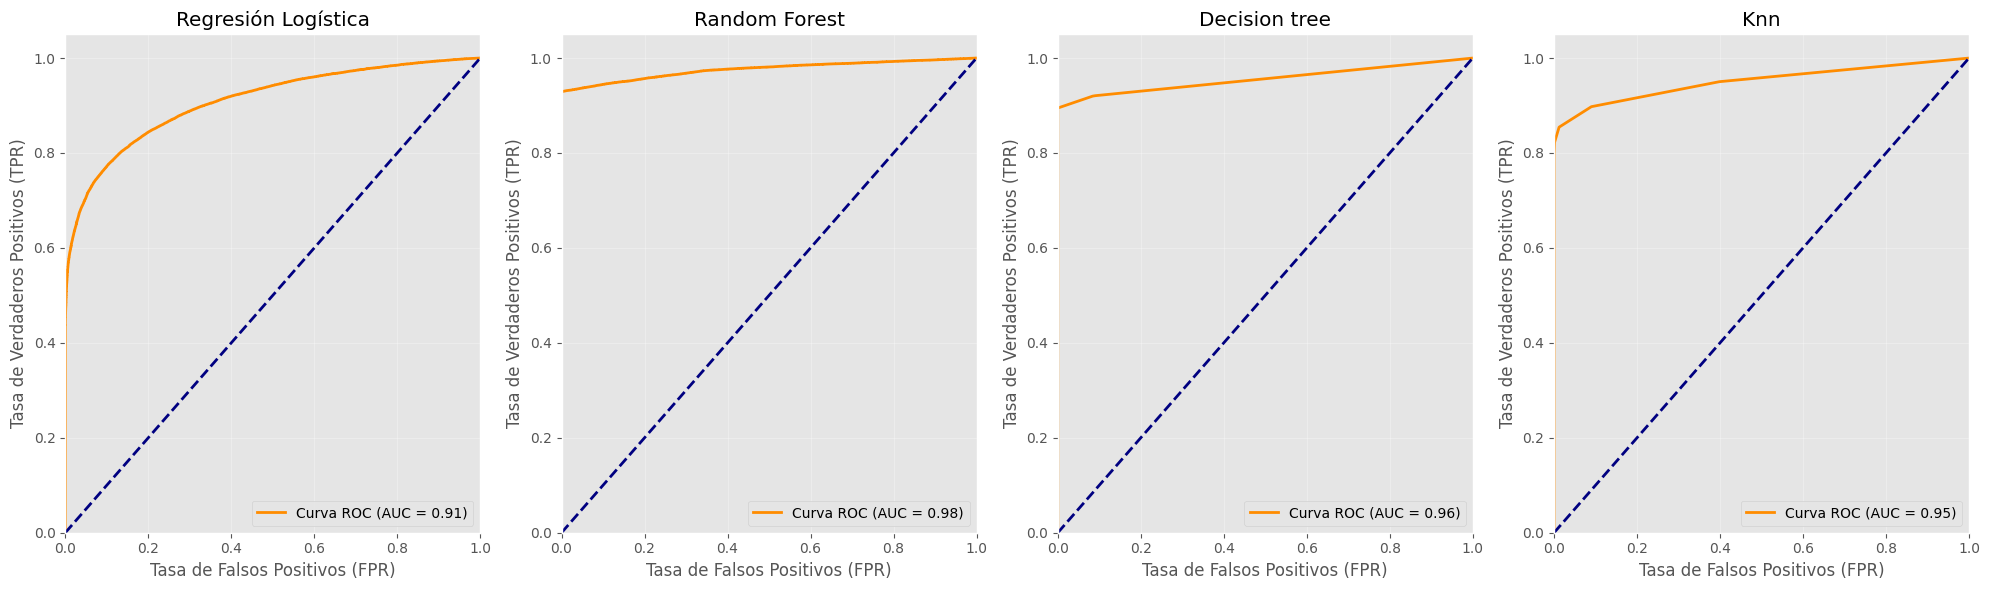

In [418]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

models = [
    ('Regresión Logística', clf),
    ('Random Forest', crf),
    ('Decision tree', tree_clf),
    ('Knn', knn),
]

for ax, (nombre, modelo) in zip(axes, models):
    
    y_probs = modelo.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Línea base aleatoria
    
    # Decoración del gráfico
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Tasa de Falsos Positivos (FPR)')
    ax.set_ylabel('Tasa de Verdaderos Positivos (TPR)')
    ax.set_title(f'{nombre}')
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Comparativa de Rendimiento de Modelos (Curvas ROC)

A partir de las gráficas de curvas ROC y los valores de AUC (Área Bajo la Curva) proporcionados, se extraen las siguientes conclusiones:

### 1. Ranking de Modelos por AUC
El valor AUC indica la capacidad del modelo para distinguir entre clases. Cuanto más cercano a 1.0, mejor es el modelo.

1.  **Random Forest:** AUC = **0.98** (Excelente / Sobresaliente)
2.  **Decision Tree:** AUC = **0.96** (Excelente)
3.  **Knn:** AUC = **0.95** (Muy bueno)
4.  **Regresión Logística:** AUC = **0.91** (Bueno)

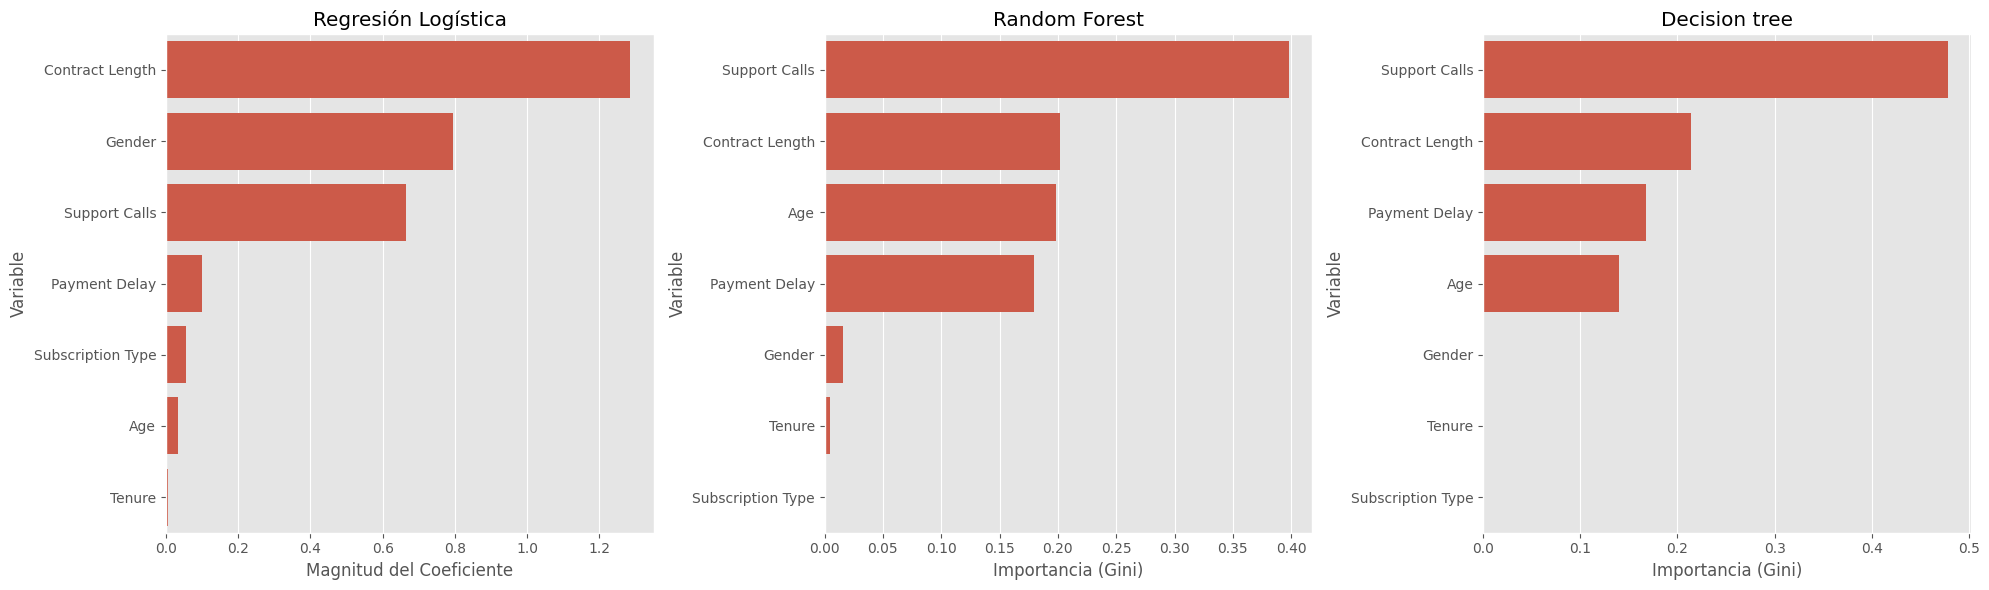

In [419]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

models = [
    ('Regresión Logística', clf),
    ('Random Forest', crf),
    ('Decision tree', tree_clf)
]

feature_names = X.columns

for ax, (nombre, modelo) in zip(axes, models):

    # Random Forest
    if hasattr(modelo, 'feature_importances_'):
        importances = modelo.feature_importances_
        xlabel = 'Importancia (Gini)'

    # Regresión Logística y SVM lineal
    elif hasattr(modelo, 'coef_'):
        importances = np.abs(modelo.coef_[0])
        xlabel = 'Magnitud del Coeficiente'

    else:
        raise ValueError(f'El modelo {nombre} no permite calcular importancias')

    feature_imp_df = (
        pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        .sort_values(by='Importance', ascending=False)
    )

    sns.barplot(
        x='Importance',
        y='Feature',
        data=feature_imp_df,
        ax=ax
    )

    ax.set_title(nombre)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Variable')

plt.tight_layout()
plt.show()

## Informe de Importancia de Variables (Feature Importance)

Este análisis detalla cómo cada modelo jerarquiza las variables para realizar sus predicciones, comparando el enfoque lineal con los modelos basados en árboles.

### 1. Análisis por Modelo

#### A. Regresión Logística (Coeficientes)
Este modelo evalúa la relación directa y lineal de cada variable.
* **Variable Dominante:** `Contract Length` es el predictor con mayor peso.
* **Impacto Secundario:** `Gender` y `Support Calls` muestran una influencia significativa.
* **Variables Irrelevantes:** `Tenure`, `Age` y `Subscription Type` tienen coeficientes cercanos a cero.

#### B. Random Forest (Importancia Gini)
Al ser un modelo de ensamble, distribuye la importancia de forma más equilibrada.
* **Líder:** `Support Calls` es el factor más crítico para la predicción.
* **Factores Relevantes:** `Contract Length`, `Age` y `Payment Delay` tienen pesos similares y significativos.
* **Baja Influencia:** `Gender` y `Tenure` aportan poco al modelo.

#### C. Decision Tree (Importancia Gini)
Muestra una estructura de decisión más agresiva y menos suavizada que el Random Forest.
* **Principal Predictor:** `Support Calls` domina la importancia con un valor cercano a 0.5.
* **Secundarios:** `Contract Length` y `Payment Delay` son las siguientes variables en la jerarquía.
* **Descartados:** `Subscription Type` y `Tenure` no tienen impacto real en las particiones del árbol.

---

### 2. Conclusiones Estratégicas

1. **El Comportamiento manda:** En los modelos con mejor rendimiento (RF y DT), las **llamadas de soporte (`Support Calls`)** son el indicador número uno, lo que sugiere que la interacción del cliente es clave para la predicción.
2. **Consistencia en Contratos:** La variable **`Contract Length`** es la única que se mantiene con alta relevancia en los tres modelos analizados.
3. **Optimización del Dataset:** Las variables **`Tenure`** y **`Subscription Type`** muestran una importancia mínima o nula en todas las gráficas, por lo que podrían eliminarse para simplificar el modelo sin perder precisión.
4. **Discrepancia en Género:** El hecho de que la Regresión Logística valore mucho el **`Gender`** pero los árboles no, indica que esta variable puede tener una correlación simple pero no es un predictor profundo en escenarios complejos.

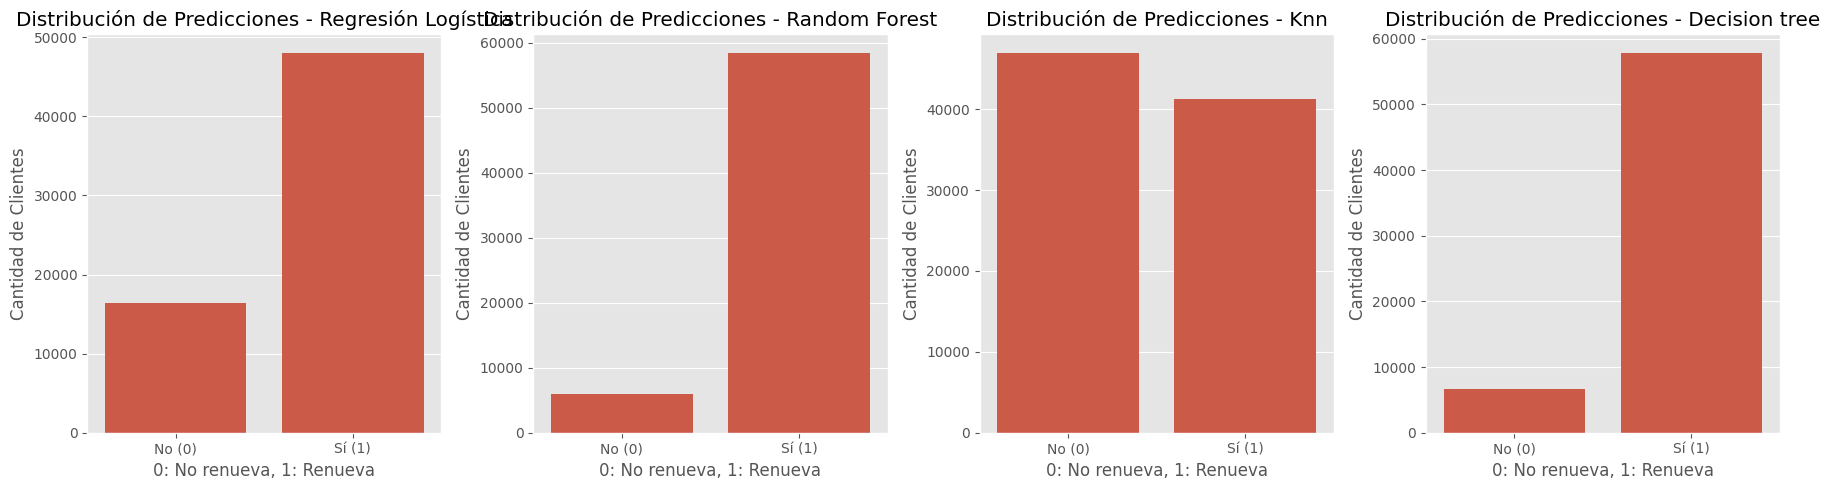

In [420]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

predicciones = [
    ('Regresión Logística', predicciones_clf),
    ('Random Forest', predicciones_crf),
    ('Knn', predicciones_knn),
    ('Decision tree', predicciones_tree_clf),
]

for ax, (nombre, preds) in zip(axes, predicciones):

    sns.countplot(x=preds, ax=ax)

    ax.set_title(f'Distribución de Predicciones - {nombre}')
    ax.set_xlabel('0: No renueva, 1: Renueva')
    ax.set_ylabel('Cantidad de Clientes')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No (0)', 'Sí (1)'])

plt.tight_layout()
plt.show()

## Análisis de Resultados: Importancia de Variables y Predicciones

### 1. Conclusiones Integradas

1.  **Sesgo de Clase:** Existe una clara tendencia en los modelos de mayor precisión (Árboles y Bosques) a predecir que la gran mayoría de los clientes **sí renovarán**. Esto podría indicar un desbalance en los datos originales o que el perfil del cliente "renovador" está muy bien definido por las llamadas de soporte y el contrato.
2.  **Anomalía en Knn:** Mientras que los demás modelos coinciden en una mayoría de "Sí", **Knn** es el único que muestra una cantidad significativa de "No renovaciones" (casi igual a las renovaciones). Esto sugiere que Knn está capturando patrones de vecindad que los modelos globales ignoran.
3.  **Perfil del Cliente que Renueva:** Según los datos, un cliente con **pocas llamadas de soporte** y un **contrato favorable** tiene una probabilidad altísima de ser clasificado como "Sí" por los modelos de Random Forest y Decision Tree.

---
**Acción Recomendada:** Dado que el modelo con mejor AUC (Random Forest) es también el más "optimista", se sugiere revisar si el negocio puede permitirse los **Falsos Negativos** (clientes que dijimos que renovarían pero no lo hicieron), ya que el modelo tiende a clasificar a casi todos como renovaciones exitosas.

### Conclusión del Análisis de Modelos

Después de evaluar varios modelos para predecir churn, se concluye que **Random Forest** es el modelo más adecuado para este problema.  

- **Accuracy más alta:** 0.96, superior a KNN (0.91), Logistic Regression (0.83) y Decision Tree (0.94).  
- **Equilibrio entre precision y recall:** identifica correctamente tanto a los clientes que permanecen como a los que abandonan, con F1-score de 0.96 para la clase Churn=1.  
- **Robustez y generalización:** al combinar múltiples árboles, Random Forest reduce el riesgo de overfitting que podría presentar un solo Decision Tree.  

En resumen, Random Forest logra un desempeño más estable y confiable, siendo la mejor opción para predecir la probabilidad de churn en este dataset.
